# Model finding

This notebook will work finding the best model to make predictions on our datas 

**Main goals are**: 
- Find or more suitable models
- Tune their parameters to improve their performances
- Evaluate their performance using different metrics

In [1]:
# Retreiving a significative amount of data
from local_lib.dataset import retreiveDatasetFromCsv

dataset = retreiveDatasetFromCsv(3000)

**Image retreiving was created due to memory problem, since it is solved by reducing csv shape it is not necessary anymore**

In [93]:
# Retreiving a significative amount of data
# from local_lib.dataset_images import retreiveDatasetFromImages

# dataset = retreiveDatasetFromImages(500)

In [2]:
dataset.iloc[0]["pixel_value"]

array([84, 81, 81, ...,  0,  0,  0], dtype=int64)

**We use a custom flatten mask to make our data compatible with machine learning models**

In [3]:
from local_lib.flatten_transformer import FlattenTransformer
from sklearn.pipeline import Pipeline
import numpy as np

pipeline = Pipeline([
    ('image_mask', FlattenTransformer()),
])

# Fit and transform data
X = pipeline.fit_transform(dataset["pixel_value"])
y = np.array(list(dataset["class"]))

In [4]:
import numpy as np
np.shape(X)

(3000, 35860)

In [5]:
from sklearn.model_selection import train_test_split
import numpy as np

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=0)

In [9]:
# First of all we will use a DummyClassifier to get an idea of what a uncorrelated model looks like
from sklearn.dummy import DummyClassifier

dummy_clf = DummyClassifier(strategy="stratified")
dummy_clf.fit(X_train, y_train)
ac = dummy_clf.score(X_test, y_test)
print("Using randomly generated answer we get " + str(ac) + "% Accuracy")

dummy_clf = DummyClassifier(strategy="most_frequent")
dummy_clf.fit(X_train, y_train)
ac = round(dummy_clf.score(X_test, y_test) * 100, 2)
print("Using only most frequent number as answer we get " + str(ac) + "% Accuracy")

dummy_clf = DummyClassifier(strategy="uniform")
dummy_clf.fit(X_train, y_train)
ac = round(dummy_clf.score(X_test, y_test) * 100, 2)
print("Using uniform distribution answer we get " + str(ac) + "% Accuracy")

Using randomly generated answer we get 0.3595959595959596% Accuracy
Using only most frequent number as answer we get 47.17% Accuracy
Using uniform distribution answer we get 34.14% Accuracy


### We can now get a first feed back from our differents data preprocessing strategies
To vizualize it we simply use a Knn models and scores it using our differents masks

**Baseline mask**

In [10]:
from sklearn.neighbors import KNeighborsClassifier
from local_lib.mask_transformer import MaskSeuilTransformer
from sklearn.pipeline import Pipeline

pipeline = Pipeline([
    ('image_mask', MaskSeuilTransformer(strategy='baseline')),
    ('knn', KNeighborsClassifier())
])

pipeline.fit(X_train, y_train)
accTrain = round(pipeline.score(X_train, y_train) * 100, 2)
accTest = round(pipeline.score(X_test, y_test) * 100, 2)
print("Combined mask accuracy is around " + str(accTrain) + "% Accuracy - [TrainSet]")
print("Combined mask accuracy is around " + str(accTest) + "% Accuracy - [TestSet]")

Combined mask accuracy is around 82.04% Accuracy - [TrainSet]
Combined mask accuracy is around 71.62% Accuracy - [TestSet]


**Geometry mask**

In [11]:
pipeline = Pipeline([
    ('image_mask', MaskSeuilTransformer(strategy='geometry')),
    ('knn', KNeighborsClassifier())
])

pipeline.fit(X_train, y_train)
accTrain = round(pipeline.score(X_train, y_train) * 100, 2)
accTest = round(pipeline.score(X_test, y_test) * 100, 2)
print("Combined mask accuracy is around " + str(accTrain) + "% Accuracy - [TrainSet]")
print("Combined mask accuracy is around " + str(accTest) + "% Accuracy - [TestSet]")

Combined mask accuracy is around 81.69% Accuracy - [TrainSet]
Combined mask accuracy is around 71.31% Accuracy - [TestSet]


**Combined mask**

In [12]:
pipeline = Pipeline([
    ('image_mask', MaskSeuilTransformer(strategy='combined')),
    ('knn', KNeighborsClassifier())
])

pipeline.fit(X_train, y_train)
accTrain = round(pipeline.score(X_train, y_train) * 100, 2)
accTest = round(pipeline.score(X_test, y_test) * 100, 2)
print("Combined mask accuracy is around " + str(accTrain) + "% Accuracy - [TrainSet]")
print("Combined mask accuracy is around " + str(accTest) + "% Accuracy - [TestSet]")

Combined mask accuracy is around 81.14% Accuracy - [TrainSet]
Combined mask accuracy is around 68.79% Accuracy - [TestSet]


### From now on, combined mask seems to really overfit wich is an unexpected behavior since his main goal was to erase parasite datas
The best one so far is the **baseline strategy**

Trying to improve performance by adding different scalers

**StandardScaler**

In [36]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_validate

pipeline = Pipeline([
    ('image_mask', MaskSeuilTransformer(strategy='baseline')),
    ('std_scaler', StandardScaler()),
    ('knn', KNeighborsClassifier())
])
cv_results = cross_validate(pipeline, X, y, cv=5, return_train_score=True)

print("Mean train score:", cv_results['train_score'].mean())
print("Mean validation score:", cv_results['test_score'].mean())

Mean train score: 0.8050833333333334
Mean validation score: 0.7316666666666667


**MinMaxScaler**

In [20]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import cross_validate

pipeline = Pipeline([
    ('image_mask', MaskSeuilTransformer(strategy='baseline')),
    ('std_scaler', MinMaxScaler()),
    ('knn', KNeighborsClassifier())
])

cv_results = cross_validate(pipeline, X, y, cv=5, return_train_score=True)

print("Mean train score:", cv_results['train_score'].mean())
print("Mean validation score:", cv_results['test_score'].mean())

Mean train score: 0.8087500000000001
Mean validation score: 0.7286666666666666


**Normalizer**

In [21]:
from sklearn.preprocessing import Normalizer
from sklearn.model_selection import cross_validate

pipeline = Pipeline([
    ('image_mask', MaskSeuilTransformer(strategy='baseline')),
    ('std_scaler', Normalizer()),
    ('knn', KNeighborsClassifier())
])

cv_results = cross_validate(pipeline, X, y, cv=5, return_train_score=True)

print("Mean train score:", cv_results['train_score'].mean())
print("Mean validation score:", cv_results['test_score'].mean())

Mean train score: 0.8045833333333332
Mean validation score: 0.7230000000000001


### Now we look for the best n_neighbors params setup

In [26]:
from sklearn.model_selection import GridSearchCV

pipeline = Pipeline([
    ('image_mask', MaskSeuilTransformer(strategy='baseline')),
    ('std_scaler', Normalizer()),
    ('knn', KNeighborsClassifier())
])

param_grid = {'knn__n_neighbors': range(1,20)}

model = GridSearchCV(
    pipeline,
    param_grid=param_grid
).fit(X, y)

ac = round(model.score(X_test, y_test) * 100, 2)
print("Scaled data upon knn accuracy is around " + str(ac) + "% Accuracy")
model.best_params_

Scaled data upon knn accuracy is around 75.15% Accuracy


{'knn__n_neighbors': 13}

**Value found produce a lower accuracy score but if we look bellow it stopped overfitting**

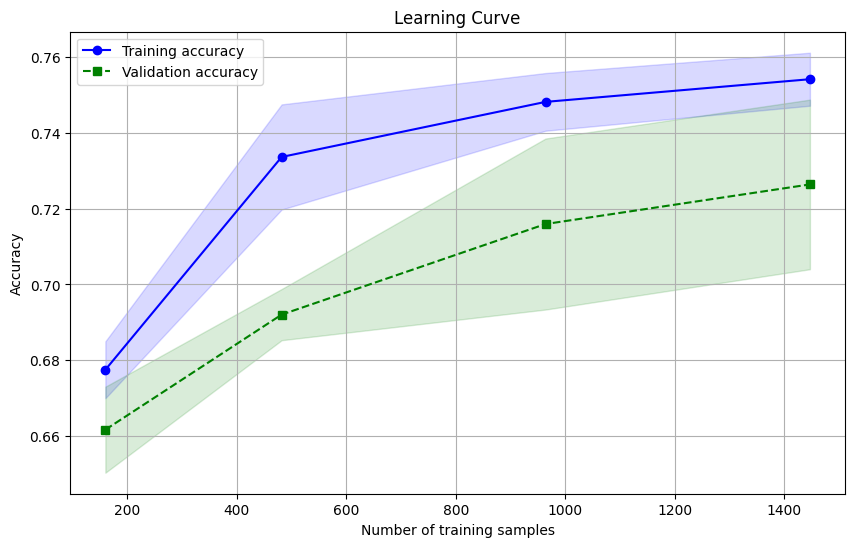

In [34]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import learning_curve
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier

# Define your pipeline
pipeline = Pipeline([
    ('image_mask', MaskSeuilTransformer(strategy='baseline')),
    ('std_scaler', StandardScaler()),
    ('knn', KNeighborsClassifier(n_neighbors=13))
])

# Plot learning curves for the best parameters
train_sizes, train_scores, test_scores = learning_curve(
    estimator=pipeline,
    X=X_train,
    y=y_train,
    train_sizes=[0.1, 0.3, 0.5, 0.6, 0.9, 1, 2],
    n_jobs=-1,
    scoring='accuracy',
    random_state=42
)

# Calculate mean and standard deviation of training scores and test scores
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

# Plot learning curve
plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_mean, color='blue', marker='o', label='Training accuracy')
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.15, color='blue')
plt.plot(train_sizes, test_mean, color='green', linestyle='--', marker='s', label='Validation accuracy')
plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, alpha=0.15, color='green')
plt.title('Learning Curve')
plt.xlabel('Number of training samples')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()


### **Trying to confirm n_neighbors value**

In [38]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_validate, RandomizedSearchCV

pipeline = Pipeline([
    ('image_mask', MaskSeuilTransformer()),
    ('std_scaler', StandardScaler()),
    ('knn', KNeighborsClassifier(n_neighbors=13))
])

param_grid = {'image_mask__strategy': ["combined", "geometry", "baseline"],
              'knn__n_neighbors': range(4,15)}

random_search = RandomizedSearchCV(
                    pipeline,
                    param_distributions=param_grid, 
                    n_iter=20,
                    cv=5,
                    scoring='accuracy',
                    random_state=42).fit(X, y)


ac = round(random_search.score(X_test, y_test) * 100, 2)
print("Randomized search acheived " + str(ac) + "% Accuracy")
random_search.best_params_

Randomized search acheived 74.85% Accuracy


{'knn__n_neighbors': 12, 'image_mask__strategy': 'geometry'}

**Trying to combine differents transformer**

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_validate, RandomizedSearchCV
from local_lib.testerTransformer import TesterTransformer

pipeline = Pipeline([
    ('image_mask', MaskSeuilTransformer()),
    ('tester_tr', TesterTransformer()),
    ('knn', KNeighborsClassifier(n_neighbors=13))
])

param_grid = {'image_mask__strategy': ["combined", "geometry", "baseline"],
              'knn__n_neighbors': range(4,15),
              'tester_tr__strategy' : ["StandardScaler","MinMaxScaler","Normalizer"]
              }

random_search = RandomizedSearchCV(
                    pipeline,
                    param_distributions=param_grid, 
                    n_iter=20,
                    cv=5,
                    scoring='accuracy',
                    random_state=42).fit(X, y)


ac = round(random_search.score(X_test, y_test) * 100, 2)
print("Randomized search acheived " + str(ac) + "% Accuracy")
random_search.best_params_